## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 08. Rainbow

[M. Hessel et al., "Rainbow: Combining Improvements in Deep Reinforcement Learning." arXiv preprint arXiv:1710.02298, 2017.](https://arxiv.org/pdf/1710.02298.pdf)

We will integrate all the following seven components into a single integrated agent, which is called Rainbow!

1. DQN
2. Double DQN
3. Prioritized Experience Replay
4. Dueling Network
5. Noisy Network
6. Categorical DQN
7. N-step Learning

This method shows an impressive performance on the Atari 2600 benchmark, both in terms of data efficiency and final performance. 

![rainbow](https://user-images.githubusercontent.com/14961526/60591412-61748100-9dd9-11e9-84fb-076c7a61fbab.png)

However, the integration is not so simple because some of components are not independent each other, so we will look into a number of points that people especailly feel confused.

1. Noisy Network <-> Dueling Network
2. Dueling Network <-> Categorical DQN
3. Categorical DQN <-> Double DQN

In [2]:
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

# download segment tree module
if IN_COLAB:
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py

from segment_tree import MinSegmentTree, SumSegmentTree

## Replay buffer

Same as the basic N-step buffer. 

(Please see *01.dqn.ipynb*, *07.n_step_learning.ipynb* for detailed description about the basic (n-step) replay buffer.)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        # Initialize buffer to store observations (state representations)
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        # Initialize buffer to store the next observations
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        # Initialize buffer to store actions taken
        self.acts_buf = np.zeros([size], dtype=np.float32)
        # Initialize buffer to store rewards received
        self.rews_buf = np.zeros([size], dtype=np.float32)
        # Initialize buffer to store done flags (True if episode ends)
        self.done_buf = np.zeros(size, dtype=np.float32)
        
        # Set the maximum buffer size and batch size for sampling
        self.max_size, self.batch_size = size, batch_size
        # Initialize pointer for the current position in the buffer
        # and variable to track the number of transitions currently stored
        self.ptr, self.size = 0, 0
        
        # For N-step Learning:
        # Create a deque to store recent transitions (of length n_step)
        self.n_step_buffer = deque(maxlen=n_step)
        # Number of steps to consider for N-step transitions
        self.n_step = n_step
        # Discount factor (gamma) used for reward calculation in N-step transitions
        self.gamma = gamma


    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        # Create a transition tuple (current state, action, reward, next state, done flag)
        transition = (obs, act, rew, next_obs, done)
        # Append the transition to the N-step buffer
        self.n_step_buffer.append(transition)

        # If the N-step buffer does not yet contain enough transitions for an N-step update
        if len(self.n_step_buffer) < self.n_step:
            return ()  # Return an empty tuple (no N-step transition available yet)
        
        # Compute the N-step reward, next observation, and done flag using the transitions
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        # Retrieve the initial observation and action from the first transition in the buffer
        obs, act = self.n_step_buffer[0][:2]
        
        # Store the computed transition components in the respective buffers
        self.obs_buf[self.ptr] = obs  # Store the initial observation
        self.next_obs_buf[self.ptr] = next_obs  # Store the N-step next observation
        self.acts_buf[self.ptr] = act  # Store the action taken
        self.rews_buf[self.ptr] = rew  # Store the N-step cumulative reward
        self.done_buf[self.ptr] = done  # Store the terminal state flag
        
        # Update the pointer to the next position (circular buffer logic)
        self.ptr = (self.ptr + 1) % self.max_size
        # Update the size of the buffer (capped at max_size)
        self.size = min(self.size + 1, self.max_size)
        
        # Return the first transition in the N-step buffer (primarily for debugging or chaining)
        return self.n_step_buffer[0]


    def sample_batch(self) -> Dict[str, np.ndarray]:
        # Randomly select a batch of indices from the stored transitions
        # `replace=False` ensures that no index is repeated in the sample
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        # Create and return a dictionary containing the sampled batch of transitions
        return dict(
            obs=self.obs_buf[idxs],          # Sampled observations (states)
            next_obs=self.next_obs_buf[idxs],  # Sampled next observations (next states)
            acts=self.acts_buf[idxs],        # Sampled actions
            rews=self.rews_buf[idxs],        # Sampled rewards
            done=self.done_buf[idxs],        # Sampled done flags (indicates terminal states)
            indices=idxs,                    # Indices of the sampled transitions (useful for tracking or debugging)
        )

    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # Retrieves a batch of transitions from the replay buffer using the provided indices
        return dict(
            obs=self.obs_buf[idxs],          # Observations (states) at the specified indices
            next_obs=self.next_obs_buf[idxs],  # Next observations (next states) at the specified indices
            acts=self.acts_buf[idxs],        # Actions taken at the specified indices
            rews=self.rews_buf[idxs],        # Rewards received at the specified indices
            done=self.done_buf[idxs],        # Done flags (indicating terminal states) at the specified indices
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # Start with the reward, next observation, and done flag of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]
        # Iterate through the transitions in reverse (excluding the last one) to compute:
        # - The total discounted reward over the n-step trajectory
        # - The next observation and done flag, adjusted to account for the earliest termination
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]
            # Accumulate discounted reward while considering termination (done)
            rew = r + gamma * rew * (1 - d)
            # Update next_obs and done; prioritize the first occurrence of 'done=True'
            next_obs, done = (n_o, d) if d else (next_obs, done)
        return rew, next_obs, done


    def __len__(self) -> int:
        # Returns the current size of the buffer (number of transitions stored)
        # This is useful for checking how many transitions are currently available in the buffer
        return self.size


## Prioritized replay Buffer

`store` method returns boolean in order to inform if a N-step transition has been generated.

(Please see *02.per.ipynb* for detailed description about PER.)

In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int,        # Dimension of the observations (e.g., for images or states)
        size: int,           # Maximum size of the replay buffer
        batch_size: int = 32, # Batch size to sample from the buffer
        alpha: float = 0.6,   # Hyperparameter controlling prioritization of experiences
        n_step: int = 1,      # Number of steps for n-step returns
        gamma: float = 0.99,  # Discount factor for future rewards
    ):
        """Initialization."""
        # Ensure that alpha is non-negative, as it controls how much priority influences sampling
        assert alpha >= 0
        # Call the parent class constructor to initialize the common buffer attributes
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        # Initialize max_priority to 1.0 and tree_ptr (pointer to the current tree index) to 0
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha  # Set alpha, which controls the prioritization
        # Ensure that the tree capacity is a power of 2 (required for Segment Trees)
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2
        # Initialize SumSegmentTree to store the sum of priorities for proportional sampling
        self.sum_tree = SumSegmentTree(tree_capacity)
        # Initialize MinSegmentTree to store the minimum priority for computing importance sampling weights
        self.min_tree = MinSegmentTree(tree_capacity)

        
    def store(
        self, 
        obs: np.ndarray,         # Current observation (state)
        act: int,                # Action taken
        rew: float,              # Reward received
        next_obs: np.ndarray,    # Next observation (state)
        done: bool,              # Whether the episode has ended
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        # Store the experience in the parent class's store method, which handles the buffer storage
        transition = super().store(obs, act, rew, next_obs, done)
        # If the experience was successfully stored (transition is not None)
        if transition:
            # Set the priority of the current experience in both SumSegmentTree and MinSegmentTree
            # The priority is set as the maximum priority raised to the power of alpha
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha   
            # Update the tree pointer (used to insert at the next index)
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        # Return the stored experience (transition)
        return transition


    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        # Assert that the current buffer size is at least as large as the batch size
        assert len(self) >= self.batch_size
        # Assert that beta is positive, as it controls the strength of the importance sampling correction
        assert beta > 0 
        # Sample a batch of indices based on priority-proportional sampling
        indices = self._sample_proportional()
        # Retrieve the corresponding experiences (observations, actions, rewards, next observations, and done flags)
        obs = self.obs_buf[indices]         # Observations (states) for the sampled indices
        next_obs = self.next_obs_buf[indices]  # Next observations (next states) for the sampled indices
        acts = self.acts_buf[indices]       # Actions taken for the sampled experiences
        rews = self.rews_buf[indices]      # Rewards received for the sampled experiences
        done = self.done_buf[indices]      # Whether the episode was done (True/False)
        # Calculate the importance-sampling weights for the sampled experiences
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        # Return a dictionary with all the relevant experience information and their importance-sampling weights
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )

        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        # Ensure that the number of indices matches the number of priorities provided
        assert len(indices) == len(priorities)
        # Iterate over each index and its corresponding priority
        for idx, priority in zip(indices, priorities):   
            # Ensure that the priority is positive, as priorities cannot be negative or zero
            assert priority > 0
            # Ensure the index is within the bounds of the buffer
            assert 0 <= idx < len(self)
            # Update the priority in both SumSegmentTree and MinSegmentTree at the specified index
            # The priority is raised to the power of alpha to control how much it influences sampling
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha
            # Update the max priority if the new priority is higher than the current max priority
            self.max_priority = max(self.max_priority, priority)

            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        # Initialize an empty list to store the sampled indices
        indices = []
        # Calculate the total sum of priorities stored in the sum tree
        # This represents the total "weight" of all experiences in the buffer
        p_total = self.sum_tree.sum(0, len(self) - 1)
        # Determine the size of each segment to divide the total priority sum into
        # This will help us sample proportional to the priorities
        segment = p_total / self.batch_size
        # Loop over the batch size to sample 'batch_size' number of experiences
        for i in range(self.batch_size):
            # Define the range for the current segment (i-th segment)
            a = segment * i  # Lower bound of the segment
            b = segment * (i + 1)  # Upper bound of the segment
            # Randomly pick a value between the lower and upper bounds of the segment
            upperbound = random.uniform(a, b)
            # Use the sum tree to retrieve the index of the experience whose cumulative priority 
            # is closest to the randomly chosen upperbound
            idx = self.sum_tree.retrieve(upperbound)
            # Append the retrieved index to the list of indices
            indices.append(idx)
        # Return the list of sampled indices
        return indices

    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # Get the minimum priority from the min_tree and normalize it by dividing by the total sum of priorities
        p_min = self.min_tree.min() / self.sum_tree.sum()
        # Calculate the maximum weight, which is used for normalizing the weight of each sample
        # The max weight is based on the minimum priority in the buffer, the total number of experiences, and the beta parameter
        max_weight = (p_min * len(self)) ** (-beta)
        # Calculate the weight for the sample at index `idx`
        # `p_sample` is the normalized priority of the experience at `idx` (i.e., priority of that sample divided by total priority sum)
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        # The weight is computed by raising `p_sample` to the power of `(-beta)`, which adjusts the importance of the sample
        weight = (p_sample * len(self)) ** (-beta)
        # Normalize the weight by dividing it by the maximum weight
        weight = weight / max_weight
        # Return the calculated weight for the experience at index `idx`
        return weight

## Noisy Layer

Please see *05.noisy_net.ipynb* for detailed description.

**References:**

- https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb
- https://github.com/Kaixhin/Rainbow/blob/master/model.py

In [5]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int,  # Number of input features to the layer
        out_features: int,  # Number of output features from the layer
        std_init: float = 0.5,  # Initial standard deviation for the noise
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()  # Call to the parent class (nn.Module) constructor
        # Store the input and output feature sizes, and the standard deviation for the noise
        self.in_features = in_features  
        self.out_features = out_features
        self.std_init = std_init
        # Create the parameters for the weight mean (mu) and standard deviation (sigma)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))  # Weight mean (mu) for the weights
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)  # Weight standard deviation (sigma) for the weights
        )
        # Register a buffer to hold the noise (epsilon) for the weights (no need to optimize this buffer)
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)  # Noise for weights
        )
        # Create the parameters for the bias mean (mu) and standard deviation (sigma)
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))  # Bias mean (mu) for the biases
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))  # Bias standard deviation (sigma) for the biases
        # Register a buffer to hold the noise (epsilon) for the biases (no need to optimize this buffer)
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))  # Noise for biases
        # Initialize the parameters (weights and biases) with reasonable values
        self.reset_parameters()
        # Initialize the noise (random noise for weights and biases)
        self.reset_noise()


    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        # Calculate the range for initializing the weight mean (mu) values
        mu_range = 1 / math.sqrt(self.in_features)  # Standard deviation scaled by input size (Xavier initialization)
        # Initialize weight mean (mu) values with a uniform distribution in the range [-mu_range, mu_range]
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        # Initialize the weight standard deviation (sigma) with a fixed value scaled by input size
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)  # Standard deviation for weights (depends on input size)
        )
        # Initialize bias mean (mu) values with a uniform distribution in the range [-mu_range, mu_range]
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        # Initialize the bias standard deviation (sigma) with a fixed value scaled by output size
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)  # Standard deviation for biases (depends on output size)
        )


    def reset_noise(self):
        """Make new noise."""
        # Generate noise for the input features using the scale_noise function
        epsilon_in = self.scale_noise(self.in_features)  # Random noise for input size
        # Generate noise for the output features using the scale_noise function
        epsilon_out = self.scale_noise(self.out_features)  # Random noise for output size
        # Outer product of the two noise vectors (input and output noise)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))  # Create the weight noise (outer product)
        # Copy the output noise directly to the bias noise
        self.bias_epsilon.copy_(epsilon_out)  # Use output noise for the bias noise


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        # Perform a linear transformation with perturbed weights and biases
        return F.linear(
            x,  # Input tensor 'x'
            # Perturbed weights: weight_mu + (weight_sigma * weight_epsilon)
            self.weight_mu + self.weight_sigma * self.weight_epsilon,  # Perturbed weights
            # Perturbed biases: bias_mu + (bias_sigma * bias_epsilon)
            self.bias_mu + self.bias_sigma * self.bias_epsilon,  # Perturbed biases
        )

    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        # Generate a tensor of random values from a normal distribution (Gaussian noise)
        x = torch.randn(size)  # Create a tensor of random values with the specified size
        # Scale the noise by taking the absolute value, then applying square root
        # The 'sign()' function preserves the sign (positive or negative) of each element in 'x'
        # The 'mul()' function performs element-wise multiplication with the transformed absolute values
        return x.sign().mul(x.abs().sqrt())  # Return scaled noise


## NoisyNet + DuelingNet + Categorical DQN

#### NoisyNet + DuelingNet

NoisyLinear is employed for the last two layers of advantage and value layers. The noise should be reset at evey update step.

#### DuelingNet + Categorical DQN

The dueling network architecture is adapted for use with return distributions. The network has a shared representation, which is then fed into a value stream with atom_size outputs, and into an advantage stream with atom_size × out_dim outputs. For each atom, the value and advantage streams are aggregated, as in dueling DQN, and then passed through a softmax layer to obtain the normalized parametric distributions used to estimate the returns’ distributions.

```
        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size)
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
```

(Please see *04.dueling.ipynb*, *05.noisy_net.ipynb*, *06.categorical_dqn.ipynb* for detailed description of each component's network architecture.)

In [6]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        self.support = support  # The set of atoms (possible Q-values).
        self.out_dim = out_dim  # Number of possible actions (output dimension).
        self.atom_size = atom_size  # Number of discrete atoms for Q-value distribution.
        # Feature layer: A fully connected layer followed by ReLU activation.
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),  # Linear layer to map input to 128 features.
            nn.ReLU(),  # ReLU activation to add non-linearity.
        )
        # Advantage layer: Two noisy layers, one for the hidden layer and one for the advantage output.
        self.advantage_hidden_layer = NoisyLinear(128, 128)  # Hidden layer with noise.
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)  # Advantage output layer with noise.
        # Value layer: Two noisy layers, one for the hidden layer and one for the value output.
        self.value_hidden_layer = NoisyLinear(128, 128)  # Hidden layer with noise.
        self.value_layer = NoisyLinear(128, atom_size)  # Value output layer with noise.


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)  # Get the distribution over actions.
        q = torch.sum(dist * self.support, dim=2)  # Compute the expected Q-value by summing over atoms.
        return q

    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)  # Extract features from the input.
        adv_hid = F.relu(self.advantage_hidden_layer(feature))  # Pass through the advantage hidden layer.
        val_hid = F.relu(self.value_hidden_layer(feature))  # Pass through the value hidden layer.
        # Advantage and value computation.
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size  # Reshape advantage to match output dimensions.
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)  # Reshape value to match atoms.
        # Compute Q-values (value + advantage - mean advantage).
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        # Apply softmax to normalize the Q-values into a probability distribution.
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # To avoid NaNs, clamp the values to a minimum of 1e-3.
        return dist

    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()  # Reset noise for advantage hidden layer.
        self.advantage_layer.reset_noise()  # Reset noise for advantage output layer.
        self.value_hidden_layer.reset_noise()  # Reset noise for value hidden layer.
        self.value_layer.reset_noise()  # Reset noise for value output layer.


## Rainbow Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

#### Categorical DQN + Double DQN

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Here, we use `self.dqn` instead of `self.dqn_target` to obtain the target actions.

```
        # Categorical DQN + Double DQN
        # target_dqn is used when we don't employ double DQN
        next_action = self.dqn(next_state).argmax(1)
        next_dist = self.dqn_target.dist(next_state)
        next_dist = next_dist[range(self.batch_size), next_action]
```

In [7]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        # Get the dimensions of the observation and action spaces from the environment
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        # Save the parameters
        self.env = env
        self.batch_size = batch_size  # Size of each batch when sampling from memory
        self.target_update = target_update  # Frequency of updating target network
        self.seed = seed  # Random seed for reproducibility
        self.gamma = gamma  # Discount factor for future rewards
        # Device setup: Use GPU if available, otherwise default to CPU
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)  # Print the device being used
        # Prioritized Experience Replay (PER) settings
        self.beta = beta  # Beta controls the importance sampling weight
        self.prior_eps = prior_eps  # Small value added to priorities to ensure no zero priorities
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha, gamma=gamma
        )  # Initialize memory buffer for experience replay with prioritization
        # N-step Learning memory
        self.use_n_step = True if n_step > 1 else False  # Flag to determine if N-step learning is used
        if self.use_n_step:
            self.n_step = n_step  # Number of steps for N-step TD learning
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )  # Initialize memory for N-step transitions 
        # Categorical DQN parameters
        self.v_min = v_min  # Minimum value of the categorical distribution support
        self.v_max = v_max  # Maximum value of the categorical distribution support
        self.atom_size = atom_size  # Number of atoms in the categorical distribution
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)  # Create a support array (uniformly spaced values between v_min and v_max)
        # Networks: initialize the DQN and target networks
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)  # Main Q-network
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)  # Target Q-network
        self.dqn_target.load_state_dict(self.dqn.state_dict())  # Initialize target network with main network weights
        self.dqn_target.eval()  # Set the target network in evaluation mode
        # Optimizer for the DQN
        self.optimizer = optim.Adam(self.dqn.parameters())  # Adam optimizer for training the DQN
        # Initialize transition list to store state transitions
        self.transition = list()
        # Mode flag (True for testing, False for training)
        self.is_test = False


    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # Pass the input state to the DQN model to get action probabilities
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()  # Choose the action with the highest probability
        # Convert the selected action to a numpy array for compatibility
        selected_action = selected_action.detach().cpu().numpy()
        # If the agent is not in test mode, store the current state and action as transition data
        if not self.is_test:
            self.transition = [state, selected_action]
        # Return the selected action
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # Take the action in the environment and get the next state, reward, 
        # whether the episode is terminated, and whether it was truncated
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated  # Determine if the episode is done
        # If the agent is not in test mode, store the transition details
        if not self.is_test:
            self.transition += [reward, next_state, done]
            # If using N-step learning, store the transition in the N-step memory
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # If using 1-step learning, store the transition in regular memory
            else:
                one_step_transition = self.transition
            # Add the transition to memory
            if one_step_transition:
                self.memory.store(*one_step_transition)
        # Return the next state, reward, and whether the episode is done
        return next_state, reward, done


    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # Sample a batch from the experience replay memory using the current beta value.
        # This is important for Prioritized Experience Replay (PER), which calculates weights based on the importance of the experiences.
        samples = self.memory.sample_batch(self.beta)
        # Retrieve the importance sampling weights and ensure they have the correct shape.
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)  # Move weights to the correct device (CPU or GPU)
        # Indices of the sampled batch, which will be used later to update priorities.
        indices = samples["indices"]
        # Compute the 1-step learning loss using the DQN loss function.
        # This is the regular loss used when the agent takes actions one step at a time.
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        # Apply importance sampling by multiplying the loss with the weights.
        # This helps in correcting the bias introduced by prioritized experience replay.
        loss = torch.mean(elementwise_loss * weights)
        # If N-step learning is enabled, we compute the N-step learning loss.
        # We combine the 1-step loss and N-step loss to avoid high variance.
        # The original Rainbow DQN algorithm uses only the N-step loss, but combining both can stabilize training.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step  # Discount factor for N-step learning
            samples = self.memory_n.sample_batch_from_idxs(indices)  # Sample N-step batch
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)  # Compute N-step loss
            elementwise_loss += elementwise_loss_n_loss  # Combine 1-step and N-step loss
            # Again apply importance sampling with the updated combined loss.
            loss = torch.mean(elementwise_loss * weights)
        # Perform gradient descent optimization step.
        self.optimizer.zero_grad()  # Reset gradients to zero before the backward pass.
        loss.backward()  # Compute gradients for backpropagation.
        # Clip the gradients to prevent large updates that might cause instability in training.
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        # Perform the optimization step, updating the DQN network's parameters.
        self.optimizer.step()
        # Update the priorities of the sampled experiences in memory.
        # This is done after the loss calculation to ensure that more important experiences are given higher priority in future sampling.
        loss_for_prior = elementwise_loss.detach().cpu().numpy()  # Detach the loss from the computation graph for priority update
        new_priorities = loss_for_prior + self.prior_eps  # Add a small constant to avoid zero priorities
        self.memory.update_priorities(indices, new_priorities)  # Update the priorities in the memory buffer
        # Reset the noise in the NoisyNet layers, as part of the NoisyNet DQN algorithm.
        self.dqn.reset_noise()  # Reset noise in the online DQN network.
        self.dqn_target.reset_noise()  # Reset noise in the target DQN network.
        # Return the computed loss value as a scalar.
        return loss.item()  # Return loss as a Python float (scaler) to avoid PyTorch tensor overhead.

        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False  # Set the agent to training mode, enabling exploration policies
        # Initialize the environment and get the initial state
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0  # Initialize the update count
        losses = []  # Initialize the list to store losses during training
        scores = []  # Initialize the list to store scores during training
        score = 0  # Initialize the score (total reward) to 0
        # Loop through each frame for training
        for frame_idx in range(1, num_frames + 1):
            # Select an action based on the current state
            action = self.select_action(state)
            # Take the selected action and get the next state, reward, and done flag
            next_state, reward, done = self.step(action)
            # Update the state and accumulate the reward
            state = next_state
            score += reward
            # NoisyNet: Removed epsilon decay logic
            # PER: Increase the importance sampling weight (beta)
            fraction = min(frame_idx / num_frames, 1.0)  # Calculate fraction for increasing beta
            self.beta = self.beta + fraction * (1.0 - self.beta)  # Increase beta gradually
            # If episode ends, reset the environment and record the score
            if done:
                state, _ = self.env.reset(seed=self.seed)  # Reset the environment
                scores.append(score)  # Append the total score of the episode
                score = 0  # Reset the score for the next episode
            # If training is ready (sufficient experience in memory)
            if len(self.memory) >= self.batch_size:
                # Update the model based on samples from the memory
                loss = self.update_model()
                losses.append(loss)  # Record the loss
                update_cnt += 1  # Increment the update count
                # Perform a hard update of the target network after certain number of updates
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            # Plot the training progress periodically
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)           
        self.env.close()  # Close the environment after training

                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        # Set the agent to test mode, disabling any exploration policies
        self.is_test = True
        # Create a recording environment to capture a video of the agent's behavior
        naive_env = self.env  # Save the original environment
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)  # Wrap the environment to record a video
        # Reset the environment and get the initial state
        state, _ = self.env.reset(seed=self.seed)  # Reset the environment and get the initial state
        done = False  # Initialize the done flag as False (episode not over)
        score = 0  # Initialize the score (total reward) to 0
        # Run the episode until done (when the agent reaches a terminal state)
        while not done:
            # Select the action based on the current state
            action = self.select_action(state)
            # Take the selected action and get the next state, reward, and done flag
            next_state, reward, done = self.step(action)
            # Update the state and accumulate the reward
            state = next_state
            score += reward  # Add the reward to the total score
        # Print the total score achieved in the episode
        print("score: ", score) 
        # Close the environment (stop video recording)
        self.env.close()
        # Restore the original environment (remove the video recording wrapper)
        self.env = naive_env


    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # Device to store tensors (either CPU or GPU)
        # Convert input samples (state, next state, action, reward, done) into tensors
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        # Categorical DQN specific parameters
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)  # Interval size for support
        with torch.no_grad():
            # Double DQN: Select actions using the main network and compute target distributions from the target network
            next_action = self.dqn(next_state).argmax(1)  # Get the best action from the main network
            next_dist = self.dqn_target.dist(next_state)  # Get the distribution from the target network
            next_dist = next_dist[range(self.batch_size), next_action]  # Select the distribution corresponding to the chosen actions
            # Compute the target distribution (t_z)
            t_z = reward + (1 - done) * gamma * self.support  # Bellman update for categorical DQN
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)  # Clamp target to within [v_min, v_max]
            b = (t_z - self.v_min) / delta_z  # Normalize target to the support
            l = b.floor().long()  # Lower bound of the target bin
            u = b.ceil().long()  # Upper bound of the target bin
            # Create an offset for indexing the target distribution
            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )
            # Project the target distribution onto the bins
            proj_dist = torch.zeros(next_dist.size(), device=self.device)  # Initialize projected distribution
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )  # Add the portion for the lower bin
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )  # Add the portion for the upper bin
        # Compute the categorical DQN loss using the projection and log of the predicted probabilities
        dist = self.dqn.dist(state)  # Get the distribution of the current state from the DQN
        log_p = torch.log(dist[range(self.batch_size), action])  # Log probabilities of chosen actions
        elementwise_loss = -(proj_dist * log_p).sum(1)  # Compute the loss for each sample
        return elementwise_loss  # Return the computed loss


    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int,  # The current frame index (or timestep) during training
        scores: List[float],  # List of scores obtained by the agent during training episodes
        losses: List[float],  # List of loss values (training loss)
    ):
        """Plot the training progress by displaying the score and loss over time."""
        clear_output(True)  # Clears previous outputs to update the plot in the notebook
        plt.figure(figsize=(20, 5))  # Set the figure size for the plot
        # Plot the scores (agent's performance over time)
        plt.subplot(131)  # Create the first subplot (score plot)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))  # Title includes the current frame index and average score over the last 10 episodes
        plt.plot(scores)  # Plot the scores over time
        # Plot the loss values (agent's training loss over time)
        plt.subplot(132)  # Create the second subplot (loss plot)
        plt.title('loss')  # Title of the plot
        plt.plot(losses)  # Plot the losses over time
        plt.show()  # Display the plot


## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [8]:
# environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

## Set random seed

In [9]:
seed = 777  # Set a specific seed value for reproducibility across runs.
def seed_torch(seed):
    """Set the seed for PyTorch to ensure reproducibility."""
    torch.manual_seed(seed)  # Set the seed for PyTorch's random number generator (CPU)
    # If using CUDA (GPU), set the seed for CUDA operations to ensure reproducibility on the GPU.
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)  # Set the seed for GPU's random number generator.
        torch.backends.cudnn.benchmark = False  # Disable benchmarking, making the convolution operations deterministic.
        torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior by using only deterministic algorithms in cuDNN.
# Set the seed for other libraries (NumPy and Python's built-in random module) to ensure the whole environment is deterministic.
np.random.seed(seed)  # Set the seed for NumPy's random number generator.
random.seed(seed)  # Set the seed for Python's built-in random module.
# Apply the seed settings to PyTorch to make its operations deterministic.
seed_torch(seed)  # This function call applies the seed settings specifically for PyTorch.


## Initialize

In [10]:
# parameters
num_frames = 12000
memory_size = 10000
batch_size = 128
target_update = 100
# train
agent = DQNAgent(env, memory_size, batch_size, target_update, seed)

cpu


## Train

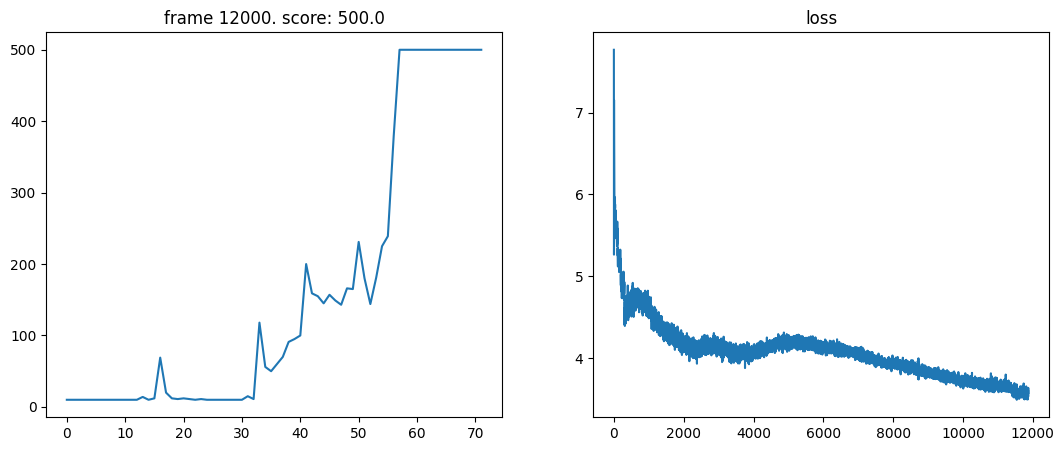

In [11]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [12]:
video_folder="videos/rainbow"
agent.test(video_folder=video_folder)

/opt/homebrew/Caskroom/miniconda/base/envs/pytorch_env/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/vishalsankarram/Desktop/github/rainbow-is-all-you-need-1/videos/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch_env/lib/python3.8/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /Users/vishalsankarram/Desktop/github/rainbow-is-all-you-need-1/videos/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/vishalsankarram/Desktop/github/rainbow-is-all-you-need-1/videos/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/vishalsankarram/Desktop/github/rainbow-is-all-you-need-1/videos/rainbow/rl-video-episode-0.mp4
score:  500.0


## Render

In [13]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/rainbow/rl-video-episode-0.mp4
